# 4) CNN

## Load Dataset and Variables

In [1]:
import pandas as pd
import pickle

In [2]:
# Load the data

major_dialog_data = pd.read_pickle("./datasets/major_dialog_data.pkl")
all_dialog_data = pd.read_pickle("./datasets/all_dialog_data.pkl")

with open('./datasets/utterances.pkl', 'rb') as f:
    utterances = pickle.load(f)
    
with open('./datasets/stop_words.pkl', 'rb') as f:
    stop_words = pickle.load(f)

# Pre-process the data similarly to workbook 0

labels = major_dialog_data.speaker

speaker_value_counts = all_dialog_data.speaker.value_counts()
major_speaker_value_counts = speaker_value_counts[speaker_value_counts > 40]
x, y = major_speaker_value_counts.index, major_speaker_value_counts.values

num_major_characters = 6

# a list of the top characters names
major_characters = x[:num_major_characters]
# a set of those same names
major_characters_set = set(major_characters)

# finally, dicts to and from class Ids and their respective names
labels_to_ids = {}
ids_to_labels = {}
for i, major_character in enumerate(major_characters):
    labels_to_ids[major_character] = i
    ids_to_labels[i] = major_character
labels_to_ids

{'Rachel': 0, 'Ross': 1, 'Chandler': 2, 'Monica': 3, 'Joey': 4, 'Phoebe': 5}

## Model - CNN
[https://arxiv.org/abs/1408.5882](https://arxiv.org/abs/1408.5882)

CNNs can learn more complex, non-linear patterns. We effectively do a 1-D convolution on the words embeddings (going back to Word2Vec). This creates a variable-length feature map for each convolutional filter. We can aggregate the feature map into a single feature using a 1-D max-pooling operation. This furnishes a hidden layer of fixed length (equal to the number of filters).

CNNs aren't as easily interpretable as logistic regression, but there are methods to glean some insight from them.

In [3]:
import math
import models.cnn as cnn
import numpy as np
import os, sys
import re
import seaborn as sn
import tensorflow as tf
import urllib.request

from datetime import datetime
from gensim.models import KeyedVectors
from importlib import reload
from IPython.display import display, Markdown
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
from util import shuffle, batch_iter, conf_matrix_plot

reload(cnn)

<module 'models.cnn' from '/home/ec2-user/SageMaker/w266-final/analysis/models/cnn.py'>

#### Load embeddings

In [4]:
root_path = Path().resolve().joinpath("..")

embeddings_path = root_path.joinpath("embeddings", "newscrawl.300d.W.pos.vectors.gz")
embeddings_url = "https://www.dropbox.com/s/kguufyc2xcdi8yk/lexvec.enwiki%2Bnewscrawl.300d.W.pos.vectors.gz?dl=1"

# downloads the Word2Vec embeddings (only need to run once)
if not os.path.isfile(embeddings_path):
    print("downloading embeddings...")
    urllib.request.urlretrieve(embeddings_url, embeddings_path)

# Uncomment below to unzip file
# !gunzip {str(embeddings_path)}

In [5]:
# load the vocabulary with the embeddings
embeddings = KeyedVectors.load_word2vec_format(root_path.joinpath("embeddings", "newscrawl.300d.W.pos.vectors"), binary=False)

In [6]:
train_cut = math.ceil(major_dialog_data.utterance.count() * 0.85)
label_ids = np.array([labels_to_ids[label] for label in labels])

cnn_tokenized = []
for utterance in major_dialog_data.utterance:
    words = re.findall(r"[a-z0-9']+", utterance.lower())
    # remove dangling apostrophes and 's at the end of words
    words = [re.sub(r"'s?$", "", word) for word in words]
    words = [re.sub(r"'", "", word) for word in words]
    cnn_tokenized.append(words)

train_x_cnn = cnn_tokenized[:train_cut]
train_y_cnn = label_ids[:train_cut]
test_x_cnn = cnn_tokenized[train_cut:]
test_y_cnn = label_ids[train_cut:]

train_x_cnn = np.array([" ".join(words) for words in train_x_cnn])
test_x_cnn = np.array([" ".join(words) for words in test_x_cnn])

In [7]:
tf.reset_default_graph()

cnn_model = cnn.CNN(embeddings, num_major_characters)

In [19]:
display_step = 20
num_epochs = 40
batch_size = 128

train_writer = tf.summary.FileWriter("./cnn-board/train")
test_writer = tf.summary.FileWriter("./cnn-board/test")
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    train_writer.add_graph(sess.graph)
    
    global_step = 0
    X = cnn_model.X
    Y = cnn_model.Y
    keep_prob = cnn_model.keep_prob

    for epoch in range(num_epochs):
        print("{} epoch number: {}".format(datetime.now(), epoch + 1))
        train_x_cnn, train_y_cnn = shuffle(train_x_cnn, train_y_cnn)
        
        for step, x_batch, y_batch in batch_iter(train_x_cnn, train_y_cnn, batch_size):
            global_step += 1
            sess.run(cnn_model.train_op, feed_dict={ X: x_batch, Y: y_batch, keep_prob: 1 })

            # every so often, report the progress of our loss and training accuracy
            if step % display_step == 0:
                summ = sess.run(cnn_model.merged_summary, feed_dict={ X: x_batch, Y: y_batch })
                train_writer.add_summary(summ, global_step=global_step)
                train_writer.flush()

        test_acc, summ = sess.run([cnn_model.accuracy, cnn_model.merged_summary], feed_dict={ X: test_x_cnn, Y: test_y_cnn })
        test_writer.add_summary(summ, global_step=global_step)
        test_writer.flush()
        print("test accuracy = {:.4f}".format(test_acc))
    
    # save the model to disk so we can load it up later for use by `./eval.py`
    saver.save(sess, "./cnn-ckpt/model.ckpt")

2018-12-06 05:52:27.374115 epoch number: 1
test accuracy = 0.2589
2018-12-06 05:52:44.327864 epoch number: 2
test accuracy = 0.2712
2018-12-06 05:52:59.251139 epoch number: 3
test accuracy = 0.2741
2018-12-06 05:53:14.511752 epoch number: 4
test accuracy = 0.2817
2018-12-06 05:53:29.466793 epoch number: 5
test accuracy = 0.2859
2018-12-06 05:53:44.849619 epoch number: 6
test accuracy = 0.2811
2018-12-06 05:53:59.979678 epoch number: 7
test accuracy = 0.2855
2018-12-06 05:54:15.204973 epoch number: 8
test accuracy = 0.2833
2018-12-06 05:54:30.041925 epoch number: 9
test accuracy = 0.2848
2018-12-06 05:54:45.136390 epoch number: 10
test accuracy = 0.2900
2018-12-06 05:54:59.768509 epoch number: 11
test accuracy = 0.2853
2018-12-06 05:55:14.605569 epoch number: 12
test accuracy = 0.2887
2018-12-06 05:55:29.460095 epoch number: 13
test accuracy = 0.2855
2018-12-06 05:55:46.239745 epoch number: 14
test accuracy = 0.2859
2018-12-06 05:56:01.345920 epoch number: 15
test accuracy = 0.2822
2018

### CNN Evaluation

We calculate a confusion matrix and some other metrics.

INFO:tensorflow:Restoring parameters from ./cnn-ckpt/model.ckpt
             precision    recall  f1-score   support

     Rachel       0.30      0.35      0.32      1296
       Ross       0.28      0.25      0.27      1193
   Chandler       0.27      0.22      0.25      1195
     Monica       0.25      0.24      0.24      1146
       Joey       0.27      0.34      0.30      1092
     Phoebe       0.26      0.22      0.24       989

avg / total       0.27      0.27      0.27      6911



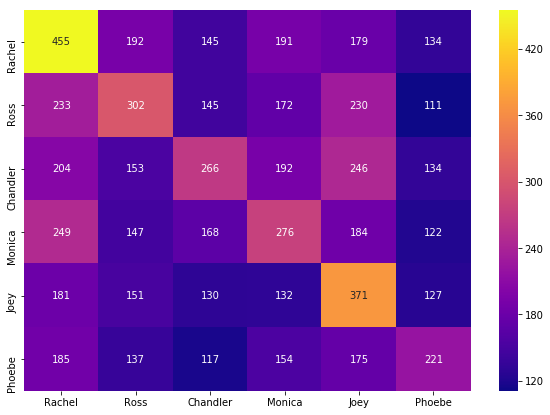

In [8]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "./cnn-ckpt/model.ckpt")
    sess.run(tf.tables_initializer())
    test_predictions = sess.run(cnn_model.predictions, feed_dict={ cnn_model.X: test_x_cnn })
    
print(classification_report(test_y_cnn, test_predictions, target_names=major_characters))

conf_matrix_plot(confusion_matrix(test_y_cnn, test_predictions), major_characters)

## Saliency Maps
[http://www.aclweb.org/anthology/N16-1082](http://www.aclweb.org/anthology/N16-1082)

This is one technique for rationalizing the inner workings of a neural network. The partial derivatives of the logits w.r.t. the inputs are taken. Those gradients with the highest magnitude can be considered the most "salient" features, as those feature contributed *most highly* to the resulting prediction.

In this cell, we take a novel line of dialog (the user can make one up), and run the prediction. But most importantly, we generate the saliency map to try to explain **why** the prediction was made.

This plot shows the time dimension of the sequence on the y-axis, and the embedding dimensions on the x-axis (300 for Word2Vec). The color in each cell is a value of the gradient for this particular prediction. The rows with cells furthest from 0 are the most salient, i.e. brightly colored rows means that word is more important for that prediction. Another way to attribute saliency to each word is by taking the norm of the gradient in that row.

In these next cells, we loop through each class and take some of the correct predictions of that class from the test set. Then, we sample some of the correct predictions and plot their saliency maps. This will show if the model is using reasonable things to make its predictions.

INFO:tensorflow:Restoring parameters from ./cnn-ckpt/model.ckpt


Text(0.5,1,'Joey')

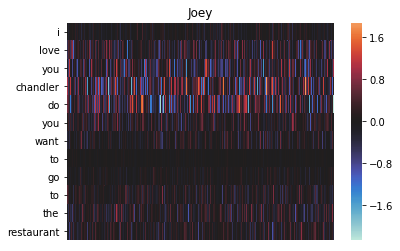

In [9]:
user_input_to_classify = "i love you chandler do you want to go to the restaurant"

with tf.Session() as sess:
    saver.restore(sess, "./cnn-ckpt/model.ckpt")
    sess.run(tf.tables_initializer())

    user_input_pred, = sess.run(cnn_model.predictions, feed_dict={ cnn_model.X: [user_input_to_classify] })
    grads = tf.gradients(cnn_model.logits[:, user_input_pred], [cnn_model.embedded])
    user_input_grads, = sess.run(grads, feed_dict={ cnn_model.X: [user_input_to_classify] })
    
sn.heatmap(user_input_grads[0], yticklabels=user_input_to_classify.split(" "), xticklabels=False, center=0)
plt.title(major_characters[user_input_pred])

In [12]:
utterances_to_plot = []
embedding_gradients_to_plot = []
original_indices = []

with tf.Session() as sess:
    saver.restore(sess, "./cnn-ckpt/model.ckpt")
    sess.run(tf.tables_initializer())

    for i in range(num_major_characters):
        correct_predictions_i = np.where(np.logical_and(test_y_cnn == i, test_predictions == i))
        grads = tf.gradients(cnn_model.logits[:, i], [cnn_model.embedded])
        embedding_gradients, = sess.run(grads, feed_dict={ cnn_model.X: test_x_cnn })
        utterances_to_plot.append(test_x_cnn[correct_predictions_i])
        embedding_gradients_to_plot.append(embedding_gradients[correct_predictions_i])
        original_indices.append(correct_predictions_i[0])

INFO:tensorflow:Restoring parameters from ./cnn-ckpt/model.ckpt


In [13]:
def show_heatmaps(utterances, gradients, xtitles, limit=9, offset=0):
    """takes a set of inputs and gradients, subsets them, and plots a heatmap"""
    plt.figure(figsize=(18, math.ceil(limit * 1.5)))
    for i, utterance in enumerate(utterances[offset:offset + limit]):
        sentence = utterance.split(" ")
        if len(sentence) > 1:
            plt.subplot(math.ceil(limit / 3), 3, i + 1)
            to_plot = gradients[offset + i][:len(sentence)]
            sn.heatmap(to_plot, yticklabels=sentence, xticklabels=False, center=0)
            plt.xlabel(xtitles[offset + i])
    plt.show()

#### Rachel

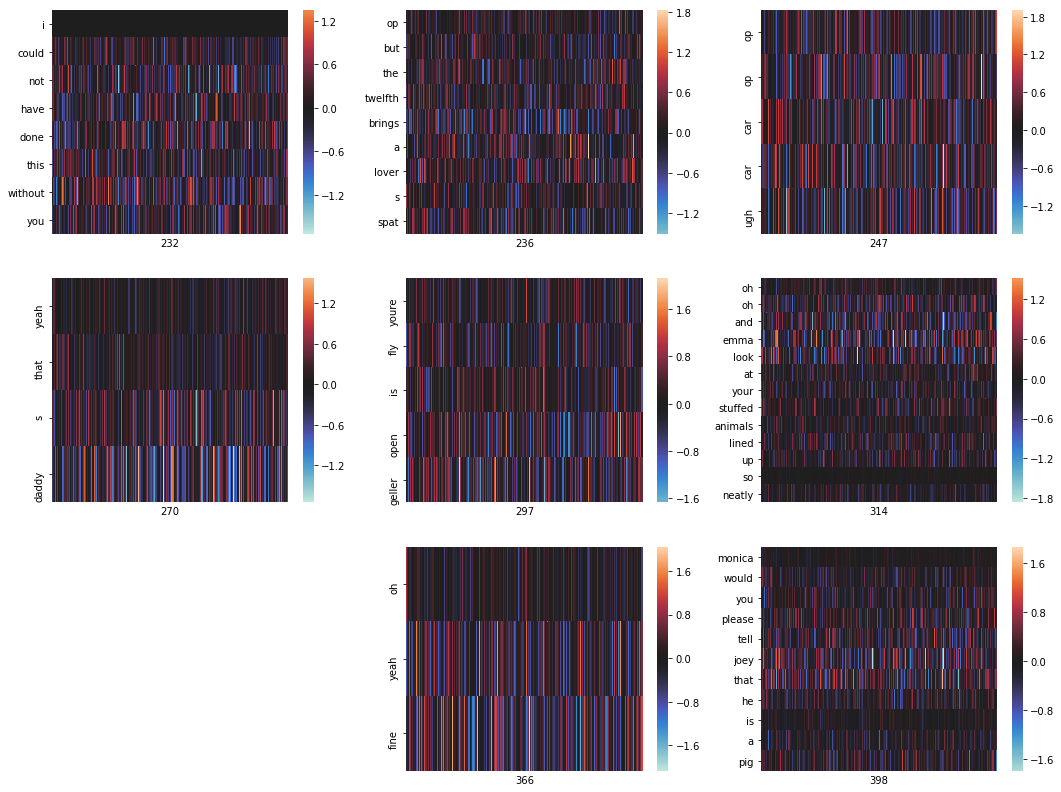

#### Ross

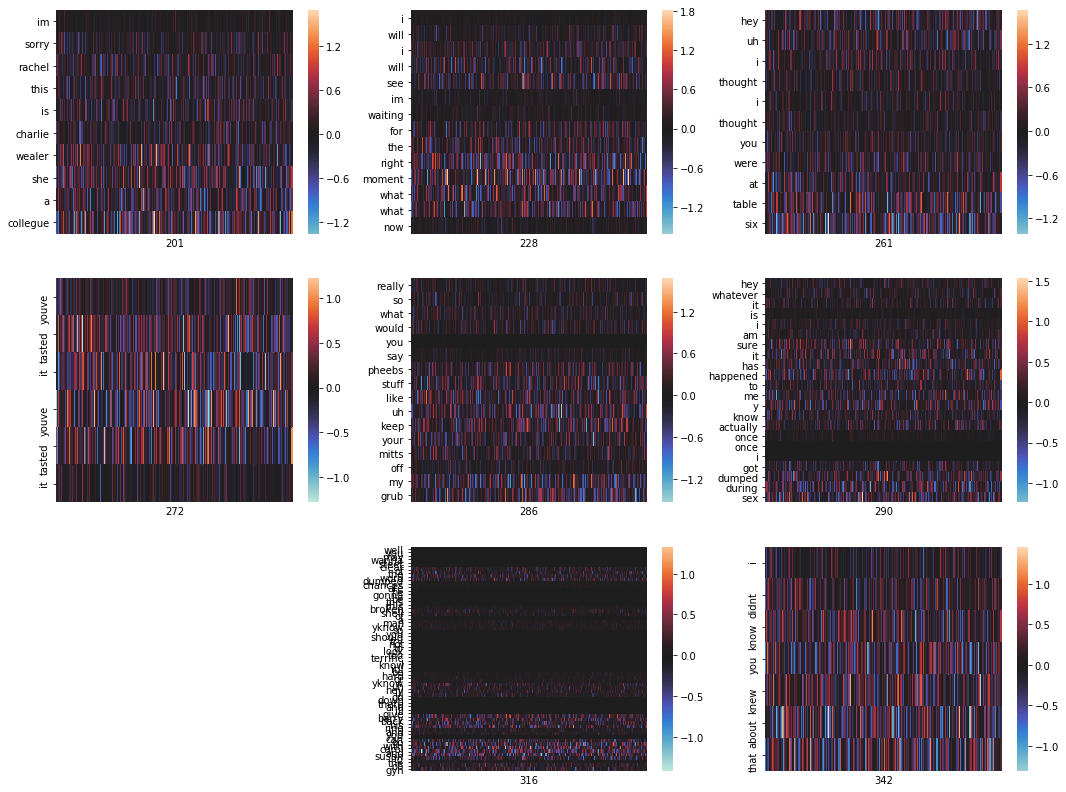

#### Chandler

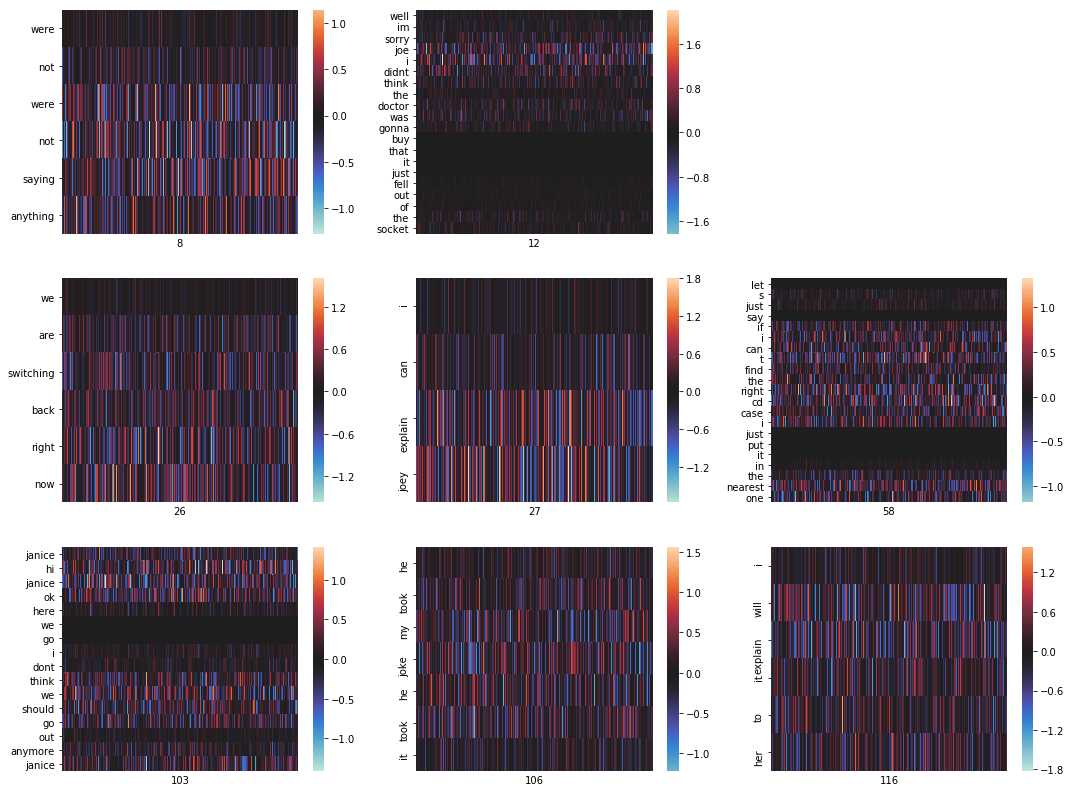

#### Monica

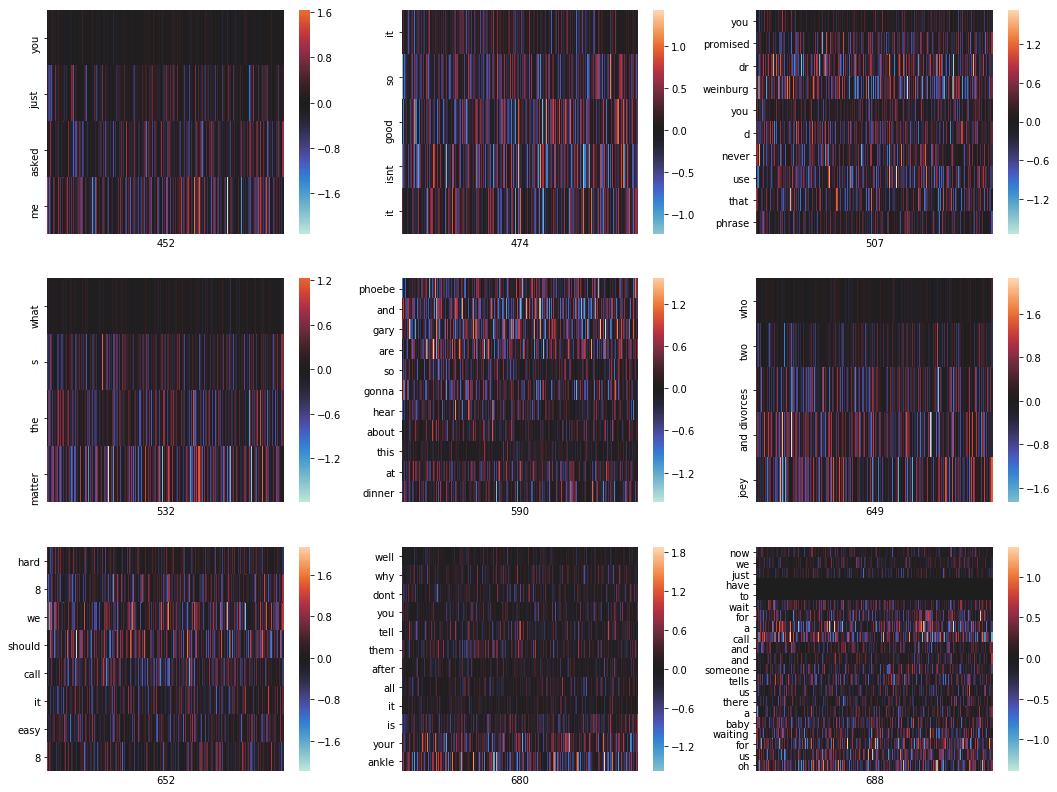

#### Joey

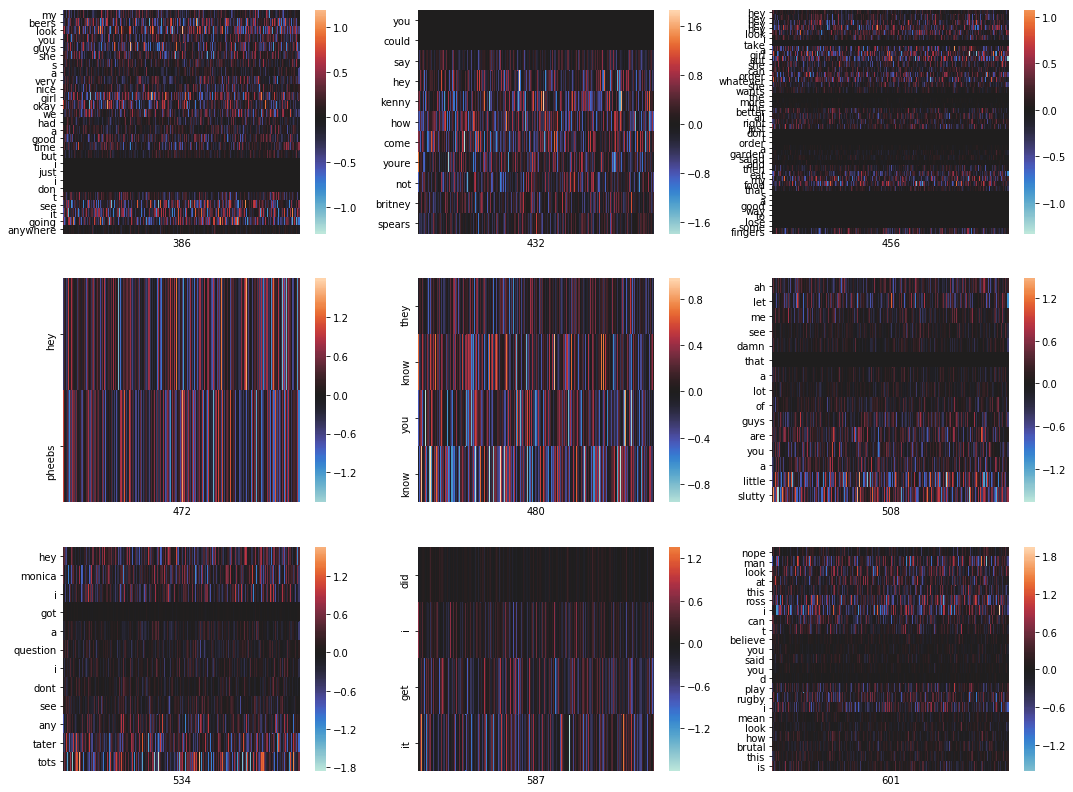

#### Phoebe

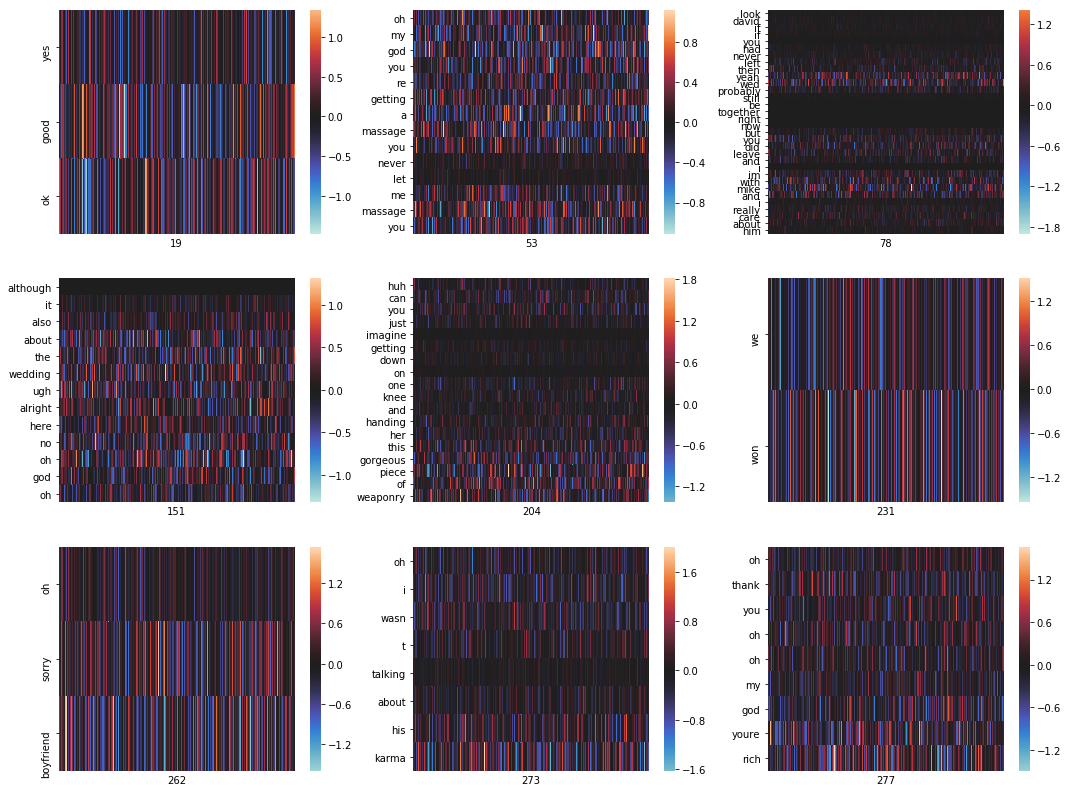

In [14]:
display_characters = [(0, 9), (1, 9), (2, 0), (3, 18), (4, 9), (5, 0)]

for char_index, offset in display_characters:
    display(Markdown("#### " + major_characters[char_index]))
    show_heatmaps(utterances_to_plot[char_index],
                  embedding_gradients_to_plot[char_index],
                  original_indices[char_index],
                  limit=9,
                  offset=offset)